In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import time
import tqdm
import json
import torch
import warnings
import numpy as np
import torch.nn as nn
from datetime import datetime
import torch.nn.functional as F
import matplotlib.pyplot as plt
from chnet.torchsummary import summary
from torchvision import transforms, utils
from toolz.curried import pipe, curry, compose
from torch.utils.data import Dataset, DataLoader

In [3]:
import utilities as utils
import chnet.cahn_hill as ch
import chnet.ch_tools as tools
from chnet.ch_loader import CahnHillDataset

In [4]:
# from chnet.unet import UNet
# from chnet.ch_net import CHnet

In [5]:
warnings.filterwarnings('ignore')

In [6]:
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

def draw_im(im, title=None):
    im = np.squeeze(im)
    plt.imshow(im)
    plt.colorbar()
    if title is not None:
        plt.title(title)
    plt.show()
    
@curry
def return_slice(x_data, cutoff):
    if cutoff is not None:
        return pipe(x_data,
                    lambda x_data: np.asarray(x_data.shape).astype(int) // 2,
                    lambda new_shape: [slice(new_shape[idim]-cutoff,
                                             new_shape[idim]+cutoff+1)
                                       for idim in range(x_data.ndim)],
                    lambda slices: x_data[slices])
    else:
        return x_data
    
cropper = return_slice(cutoff=5)

In [7]:
def init_unif(nsamples, dim_x, dim_y, seed=354875):
    np.random.seed(seed)
    return np.random.uniform(-0.98, 0.98, size=(nsamples, dim_x, dim_y))


def init_norm(nsamples, dim_x, dim_y, seed=354875):
    np.random.seed(seed)
    means  = np.random.uniform(-0.7, 0.7, size=nsamples)
    np.random.seed(seed)
    scales  = np.random.uniform(0.1, 0.5, size=nsamples)
    
    x_data = [np.random.normal(loc=m, scale=s, size = (1, dim_x, dim_y)) for m,s in zip(means, scales)]
    x_data = np.concatenate(x_data, axis=0)
    
    np.clip(x_data, -0.98, 0.98, out=x_data)
    
    return x_data

## Loss Functions

In [8]:
@curry
def mse_loss(y1, y2, scale=1.):
    """standard MSE definition"""
    return ((y1 - y2) ** 2).sum() / y1.data.nelement() * scale

@curry
def rmse_loss(y1, y2, scale=1.):
    """standard RMSE definition"""
    return ((((y1 - y2) ** 2).sum() / y1.data.nelement()).sqrt()) * scale


def mse_loss_npy(y1, y2):
    """standard MSE definition"""
    return np.sum(((y1 - y2) ** 2)) / y1.size

## Transformers

In [9]:
@curry
def add_neighbors(x):
    dimx = x.shape[0]
    y = np.pad(x, pad_width=[[2,2],[2,2]], mode="wrap")
    out = [x[None]]
    for ix in [0, 1, 2, 3, 4]:
        for iy in [0, 1, 2, 3, 4]:
            out.append((y[ix:ix+dimx, iy:iy+dimx] * x)[None])
    return np.concatenate(out, axis=0)

## Data Generators

In [10]:
@curry
def data_generator(nsamples=128, 
                   dim_x=64, 
                   init_steps=100, 
                   delta_sim_steps = 500,
                   dx = 0.25, 
                   dt = 0.01,
                   gamma=1.0, 
                   seed = None,
                   device = torch.device("cuda:0")):
    
    init_data1 = init_unif(nsamples//2, dim_x, dim_x, seed=seed)
    init_data2 = init_norm(nsamples//2, dim_x, dim_x, seed=seed)
    init_data = np.concatenate([init_data1, init_data2], axis=0)
    
    x_data = ch.ch_run_torch(init_data, dt=dt, gamma=gamma, 
                             dx=dx, sim_step=init_steps, device=device)
    y_data = ch.ch_run_torch(x_data, dt=dt, gamma=gamma, 
                             dx=dx, sim_step=delta_sim_steps, device=device)
    return x_data, y_data

In [11]:
x_data, y_data = data_generator(nsamples=16, dim_x=64, 
                                init_steps=10, 
                                delta_sim_steps = 50,
                                dx = 0.25, 
                                dt = 0.01,
                                gamma=1.0, 
                                seed = None,
                                device = torch.device("cuda:0"))

# Set Device

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# CNN Model

In [13]:
from pytorch3dunet.unet3d.model import UNet2D
from chnet.nest import U_Net

In [19]:
transformer_x = lambda x: x[None]
transformer_y = lambda x: x[None]
# from pymks.bases import LegendreBasis
# n_states = 3
# domain = (-1.01, 1.01)
# basis = LegendreBasis(n_states, domain)
# transformer_x = lambda x: np.moveaxis(basis.discretize(x), 2, 0)
# transformer_y = lambda x: x[None]



dataset = CahnHillDataset(x_data, y_data, transform_x=transformer_x, transform_y=transformer_y)

item = dataset[0]
x = item["x"][None].to(device)
y = item["y"][None].to(device)

print(x.shape, y.shape)

torch.Size([1, 1, 64, 64]) torch.Size([1, 1, 64, 64])


In [22]:
# model = UNet2D(in_channels=1, 
#                out_channels=1, 
#                is_segmentation=False).double().to(device)

model = U_Net(in_ch=1, out_ch=1).double().cuda()

item = dataset[0]
x = item["x"][None].to(device)
y = item["y"][None].to(device)
y_pred = model(x)

assert y.shape == y_pred.shape
print(mse_loss(y, y_pred).data)

tensor(0.1394, device='cuda:0', dtype=torch.float64)


# Model Training

### Training and Validation data generation

In [86]:
## Process Parameters
dim_x=64
init_steps=1
delta_sim_steps = 2000
dx = 0.25 
dt = 0.01
gamma=1.0

seed_trn = 110364
seed_val = 986423
seed_prd = 284296


trn_size = 15
n_samples_trn = 1024*trn_size
n_samples_val = 128
n_samples_prd = 32

init_features=32

args = {}
args["dim_x"] = dim_x
args["init_steps"] = init_steps
args["delta_sim_steps"] = delta_sim_steps
args["dx"] = dx
args["dt"] = dt
args["gamma"] = gamma
args["seed_trn"] = seed_trn
args["seed_val"] = seed_val
args["seed_val"] = seed_prd

args["n_samples_trn"] = n_samples_trn
args["n_samples_val"] = n_samples_val
args["n_samples_prd"] = n_samples_prd

args["init_features"] = init_features

In [87]:
%%time
x_trn, y_trn = data_generator(nsamples=n_samples_trn, 
                              dim_x=dim_x, 
                                init_steps=init_steps, 
                                delta_sim_steps = delta_sim_steps,
                                dx = dx, 
                                dt = dt,
                                gamma=gamma, 
                                seed =seed_trn,
                                device = device)



x_val, y_val = data_generator(nsamples=n_samples_val, 
                              dim_x=dim_x, 
                                init_steps=init_steps, 
                                delta_sim_steps = delta_sim_steps,
                                dx = dx, 
                                dt = dt,
                                gamma=gamma, 
                                seed =seed_val,
                                device = device)

x_prd, y_prd = data_generator(nsamples=n_samples_prd, 
                              dim_x=dim_x, 
                                init_steps=init_steps, 
                                delta_sim_steps = delta_sim_steps,
                                dx = dx, 
                                dt = dt,
                                gamma=gamma, 
                                seed =seed_prd,
                                device = device)

CPU times: user 28.9 s, sys: 27.7 s, total: 56.6 s
Wall time: 55.2 s


In [88]:
# from pymks.bases import LegendreBasis

# n_states = 7
# domain = (-1.01, 1.01)
# basis = LegendreBasis(n_states, domain)
# transformer_x = lambda x: np.moveaxis(basis.discretize(x), 2, 0)
transformer_x = lambda x: x[None]
transformer_y = lambda x: x[None]

trn_dataset = CahnHillDataset(x_trn, y_trn, transform_x=transformer_x, transform_y=transformer_y)
val_dataset = CahnHillDataset(x_val, y_val, transform_x=transformer_x, transform_y=transformer_y)
prd_dataset = CahnHillDataset(x_prd, y_prd, transform_x=transformer_x, transform_y=transformer_y)

batch_size = 8

trn_loader = DataLoader(trn_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
prd_loader = DataLoader(prd_dataset, batch_size=8, shuffle=True, num_workers=1)


total_step = len(trn_loader)
print("No. of training steps: %d" % total_step)
total_val_step = len(val_loader)
print("No. of validation steps: %d" % total_val_step)
total_val_step = len(prd_loader)
print("No. of prediction steps: %d" % total_val_step)

No. of training steps: 1920
No. of validation steps: 16
No. of prediction steps: 4


In [89]:
dt_string = datetime.now().strftime("%d-%m-%Y-%H-%M")

In [90]:
run_id = dt_string + "_run_leg_{}_data_{}_UNetNest".format(1, trn_size)
print(run_id)

folder = "out/UNetNest/ch_unet_id_{}/".format(run_id)
print(folder)


tag = folder+"unet_"
print(tag)

05-05-2020-02-22_run_leg_1_data_15_UNetNest
out/UNetNest/ch_unet_id_05-05-2020-02-22_run_leg_1_data_15_UNetNest/
out/UNetNest/ch_unet_id_05-05-2020-02-22_run_leg_1_data_15_UNetNest/unet_


In [91]:
if not os.path.exists(folder):
    os.makedirs(folder)
    
with open(folder+'params.json', 'w') as fp:
    json.dump(args, fp)

In [92]:
from chnet.nest import R2AttU_Net, AttU_Net, NestedUNet, R2U_Net, U_Net
# model = UNet2D(in_channels=1, 
#                out_channels=1, 
#                is_segmentation=False).double().to(device)
# model = U_Net(in_ch=1, out_ch=1).double().cuda()
model = R2AttU_Net(in_ch=1, out_ch=1).double().cuda()
# model = NestedUNet(in_ch=1, out_ch=1).double().cuda()
# model = R2U_Net(img_ch=1, output_ch=1).double().cuda()

In [93]:
num_epochs = 5
criterion = mse_loss(scale=10000)
learning_rate = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
trn_losses = []
val_losses = []

In [94]:
n_params = 0
for params in model.parameters():
    n_params += np.prod(params.shape)
#     print(np.prod(params.shape))
print(n_params)

39442797


In [95]:
# Loss and optimizer
for epoch in range(num_epochs):    
    torch.save(model.state_dict(), tag+"epoch_{}.pt".format(epoch))              
    for i, item_trn in enumerate(tqdm.tqdm_notebook(trn_loader)):
        
        
        model.train()
        
        x = item_trn['x'].to(device)
        y_t = item_trn['y'].to(device)

        # Forward pass
        y_p = model(x)
        loss = criterion(y_t, y_p)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        trn_losses.append(np.sqrt(loss.item()))
        
        if (i) % 128 == 0:
            for item_val in val_loader:
                model.eval()
                x1 = item_trn['x'].to(device)
                y1 = item_trn['y'].to(device)
                # Forward pass
                y2 = model(x1)
                val_losses.append(np.sqrt(criterion(y2, y1).item()))
                    
            print ('Epoch [{}/{}], Step [{}/{}], Training Loss: {:.11f}, Validation Loss: {:.11f}'.format(epoch+1, 
                                                                                                          num_epochs, 
                                                                                                          i+1, 
                                                                                                          total_step, 
                                                                                                          np.mean(trn_losses[-16:]), 
                                                                                                          np.mean(val_losses[-total_val_step:])))
            
torch.save(model.state_dict(), tag+"epoch_{}.pt".format(num_epochs)) 
torch.save(trn_losses, tag+"trn_loss.pt")
torch.save(val_losses, tag+"val_loss.pt")

Epoch [1/5], Step [1/1920], Training Loss: 64.83029595457, Validation Loss: 49.91993369369
Epoch [1/5], Step [129/1920], Training Loss: 44.53008750990, Validation Loss: 50.57594753502
Epoch [1/5], Step [257/1920], Training Loss: 40.20049748035, Validation Loss: 50.34281872723
Epoch [1/5], Step [385/1920], Training Loss: 39.81742784883, Validation Loss: 48.24937968297
Epoch [1/5], Step [513/1920], Training Loss: 37.41116201449, Validation Loss: 48.84829479933
Epoch [1/5], Step [641/1920], Training Loss: 34.94813247392, Validation Loss: 44.29934714353
Epoch [1/5], Step [769/1920], Training Loss: 34.04343827388, Validation Loss: 46.84016058624
Epoch [1/5], Step [897/1920], Training Loss: 32.16610671390, Validation Loss: 47.58083975633
Epoch [1/5], Step [1025/1920], Training Loss: 30.41944942713, Validation Loss: 45.62501050702
Epoch [1/5], Step [1153/1920], Training Loss: 30.23940707844, Validation Loss: 49.50025587534
Epoch [1/5], Step [1281/1920], Training Loss: 27.41337377815, Validati

Epoch [2/5], Step [1/1920], Training Loss: 23.71487569258, Validation Loss: 45.39472043208
Epoch [2/5], Step [129/1920], Training Loss: 22.75358708983, Validation Loss: 50.22616082141
Epoch [2/5], Step [257/1920], Training Loss: 22.30981479752, Validation Loss: 39.96641963046
Epoch [2/5], Step [385/1920], Training Loss: 22.07352112642, Validation Loss: 40.11035686191
Epoch [2/5], Step [513/1920], Training Loss: 21.04362474312, Validation Loss: 48.63940571650
Epoch [2/5], Step [641/1920], Training Loss: 19.78701426173, Validation Loss: 43.94141779665
Epoch [2/5], Step [769/1920], Training Loss: 19.50244002170, Validation Loss: 53.12417126231
Epoch [2/5], Step [897/1920], Training Loss: 19.11143703862, Validation Loss: 40.23109212001
Epoch [2/5], Step [1025/1920], Training Loss: 18.30602844348, Validation Loss: 44.07738443069
Epoch [2/5], Step [1153/1920], Training Loss: 17.57810299850, Validation Loss: 44.63877077356
Epoch [2/5], Step [1281/1920], Training Loss: 16.25378908115, Validati

Epoch [3/5], Step [1/1920], Training Loss: 15.13916242118, Validation Loss: 46.32151692971
Epoch [3/5], Step [129/1920], Training Loss: 14.57551355577, Validation Loss: 48.04685668655
Epoch [3/5], Step [257/1920], Training Loss: 15.28439474374, Validation Loss: 44.17028435645
Epoch [3/5], Step [385/1920], Training Loss: 13.65257716960, Validation Loss: 43.61006248554
Epoch [3/5], Step [513/1920], Training Loss: 13.22713090720, Validation Loss: 36.55328578088
Epoch [3/5], Step [641/1920], Training Loss: 13.92812026964, Validation Loss: 37.56255688863
Epoch [3/5], Step [769/1920], Training Loss: 14.27874575815, Validation Loss: 46.61616495346
Epoch [3/5], Step [897/1920], Training Loss: 13.59243351614, Validation Loss: 47.39359954200
Epoch [3/5], Step [1025/1920], Training Loss: 12.98098011046, Validation Loss: 40.88673544923
Epoch [3/5], Step [1153/1920], Training Loss: 13.39607121426, Validation Loss: 45.15017765363
Epoch [3/5], Step [1281/1920], Training Loss: 12.76792052236, Validati

Epoch [4/5], Step [1/1920], Training Loss: 11.84949329350, Validation Loss: 43.40658222479
Epoch [4/5], Step [129/1920], Training Loss: 11.57686750571, Validation Loss: 46.18672290368
Epoch [4/5], Step [257/1920], Training Loss: 11.70367789075, Validation Loss: 41.97446936697
Epoch [4/5], Step [385/1920], Training Loss: 13.65627935278, Validation Loss: 44.14670977004
Epoch [4/5], Step [513/1920], Training Loss: 11.38265938366, Validation Loss: 40.90607315400
Epoch [4/5], Step [641/1920], Training Loss: 11.54080142026, Validation Loss: 47.22727220348
Epoch [4/5], Step [769/1920], Training Loss: 11.35532765802, Validation Loss: 43.61261623628
Epoch [4/5], Step [897/1920], Training Loss: 11.25743584447, Validation Loss: 50.65573670086
Epoch [4/5], Step [1025/1920], Training Loss: 12.30939582730, Validation Loss: 42.79867660829
Epoch [4/5], Step [1153/1920], Training Loss: 10.12520065454, Validation Loss: 43.34240679363
Epoch [4/5], Step [1281/1920], Training Loss: 10.36591468905, Validati

Epoch [5/5], Step [1/1920], Training Loss: 10.11669489243, Validation Loss: 42.12346764260
Epoch [5/5], Step [129/1920], Training Loss: 9.66871723024, Validation Loss: 45.19470690683
Epoch [5/5], Step [257/1920], Training Loss: 9.65752008504, Validation Loss: 41.51697847390
Epoch [5/5], Step [385/1920], Training Loss: 10.20418911465, Validation Loss: 46.57853480826
Epoch [5/5], Step [513/1920], Training Loss: 10.20760230277, Validation Loss: 38.66385164003
Epoch [5/5], Step [641/1920], Training Loss: 9.37788646265, Validation Loss: 46.35913702576
Epoch [5/5], Step [769/1920], Training Loss: 9.22647578214, Validation Loss: 46.49961384627
Epoch [5/5], Step [897/1920], Training Loss: 10.55808975056, Validation Loss: 42.39777054364
Epoch [5/5], Step [1025/1920], Training Loss: 8.97933308730, Validation Loss: 39.62857574199
Epoch [5/5], Step [1153/1920], Training Loss: 9.65249286987, Validation Loss: 42.37849336876
Epoch [5/5], Step [1281/1920], Training Loss: 9.48829036630, Validation Loss

In [67]:
# prd_losses = []
# for item_prd in trn_loader:
#     model.eval()
#     x1 = item_prd['x'].to(device)
#     y1 = item_prd['y'].to(device)
#     # Forward pass
#     y2 = model(x1)
#     prd_losses.append(np.sqrt(criterion(y2, y1).item()))
# print(np.mean(prd_losses), np.std(prd_losses))

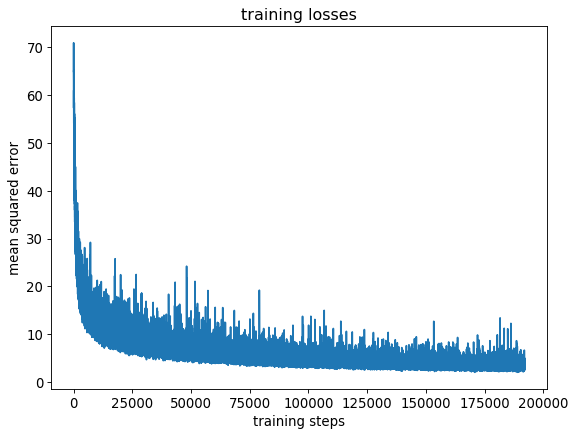

In [48]:
plt.plot(trn_losses)
# plt.plot(val_losses)
plt.title("training losses")
plt.xlabel("training steps")
plt.ylabel("mean squared error")
# plt.legend(["trn", "val"])
plt.show()

In [56]:
err = []
for ix, item_prd in enumerate(prd_dataset):
    x1 = item_prd['x'][None].to(device)
    y1 = item_prd['y'][None].to(device)
    y2 = model(x1)
    err.append(np.sqrt(mse_loss(y1.detach().cpu(), y2.detach().cpu())))

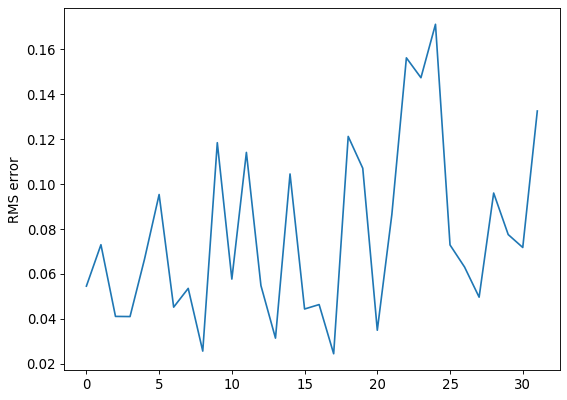

Mean Error on Validation Set: 0.0774


In [59]:
plt.plot(np.arange(len(prd_dataset)), err)
plt.ylabel("RMS error")
plt.show()

print("Mean Error on Validation Set: {:1.4f}".format(np.mean(err)))

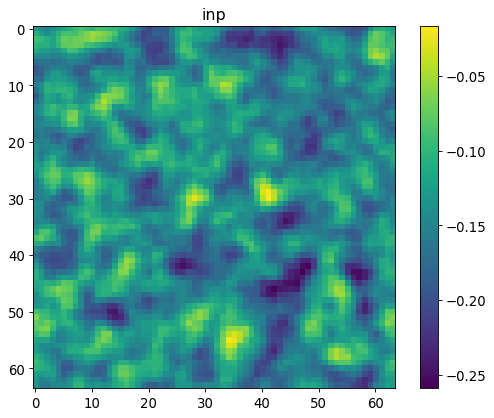

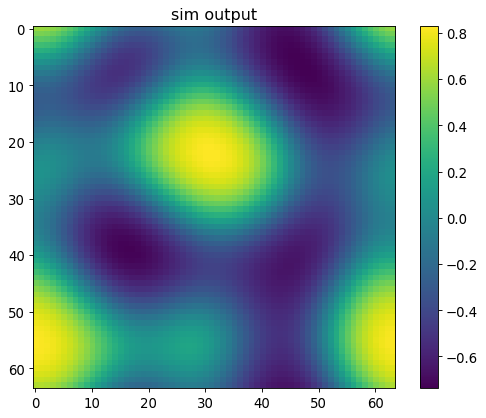

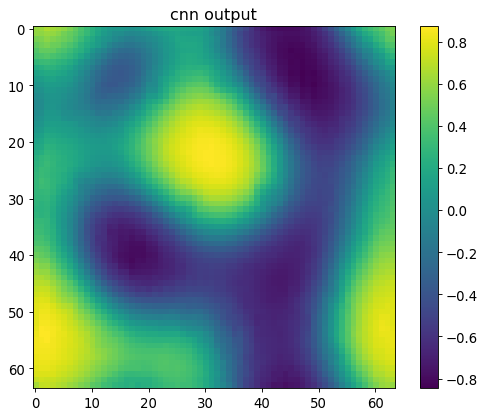

tensor(0.0292, device='cuda:0', dtype=torch.float64)


In [58]:
ix = 24

item_prd = prd_dataset[ix]
x1 = item_prd['x'][None].to(device)
y1 = item_prd['y'][None].to(device)
y2 = model(x1)

im_x1 = x1[0].detach().cpu().numpy()
im_y1 = y1[0].detach().cpu().numpy()
im_y2 = y2[0].detach().cpu().numpy()

draw_im(im_x1[1], "inp")
draw_im(im_y1, "sim output")
draw_im(im_y2, "cnn output")

print(mse_loss(y1, y2).data)

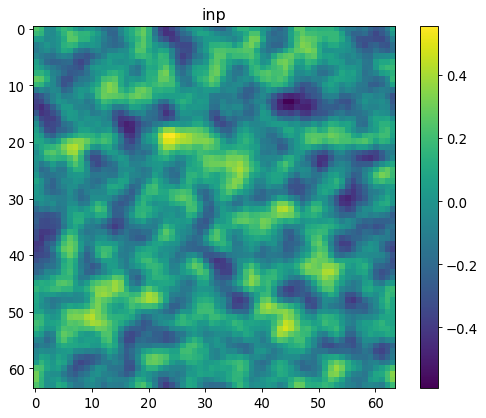

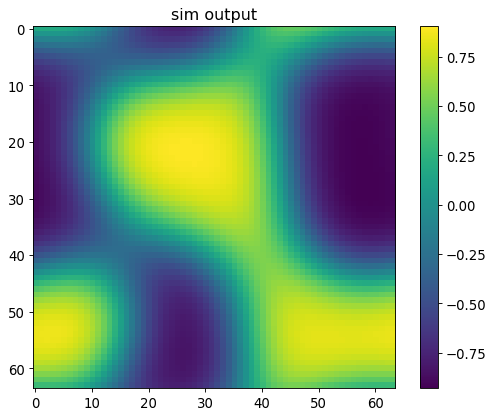

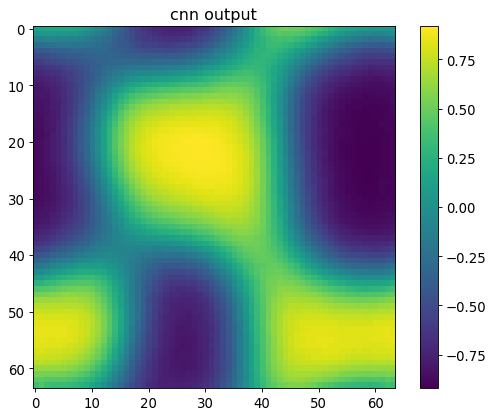

tensor(0.0030, device='cuda:0', dtype=torch.float64)


In [50]:
ix = 12

item_prd = prd_dataset[ix]
x1 = item_prd['x'][None].to(device)
y1 = item_prd['y'][None].to(device)
y2 = model(x1)

im_x1 = x1[0].detach().cpu().numpy()
im_y1 = y1[0].detach().cpu().numpy()
im_y2 = y2[0].detach().cpu().numpy()

draw_im(im_x1[1], "inp")
draw_im(im_y1, "sim output")
draw_im(im_y2, "cnn output")

print(mse_loss(y1, y2).data)

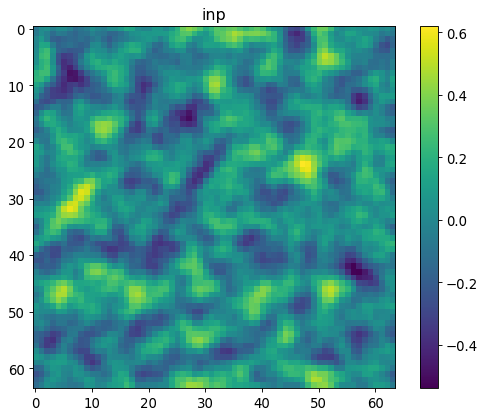

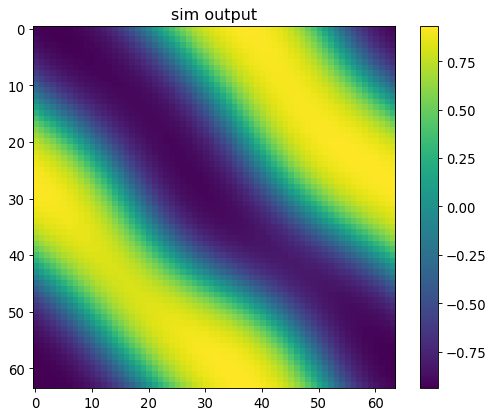

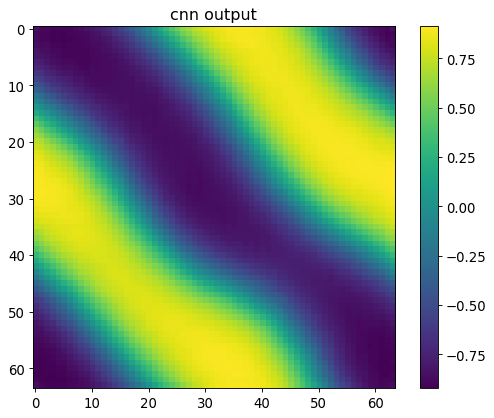

tensor(0.0017, device='cuda:0', dtype=torch.float64)


In [51]:
ix = 3

item_prd = prd_dataset[ix]
x1 = item_prd['x'][None].to(device)
y1 = item_prd['y'][None].to(device)
y2 = model(x1)

im_x1 = x1[0].detach().cpu().numpy()
im_y1 = y1[0].detach().cpu().numpy()
im_y2 = y2[0].detach().cpu().numpy()

draw_im(im_x1[1], "inp")
draw_im(im_y1, "sim output")
draw_im(im_y2, "cnn output")

print(mse_loss(y1, y2).data)

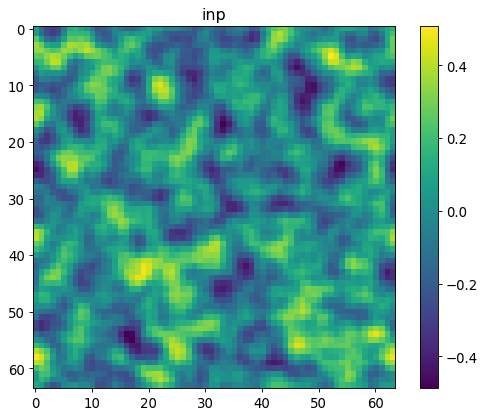

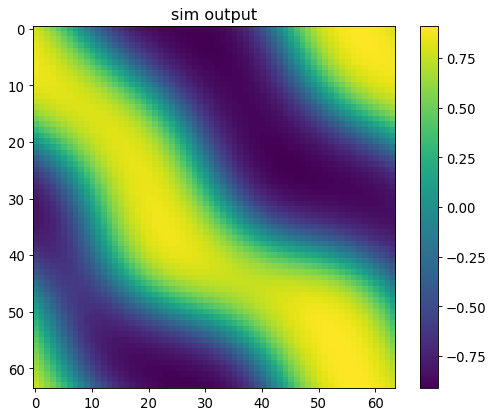

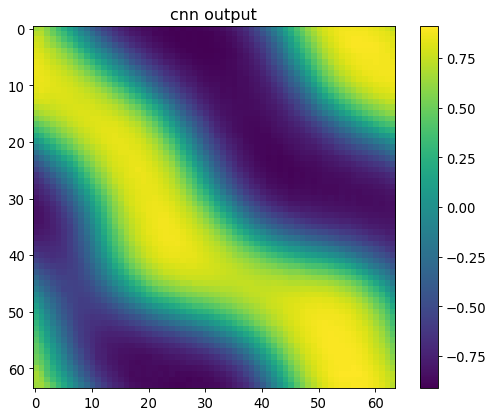

tensor(0.0020, device='cuda:0', dtype=torch.float64)


In [52]:
ix = 15

item_prd = prd_dataset[ix]
x1 = item_prd['x'][None].to(device)
y1 = item_prd['y'][None].to(device)
y2 = model(x1)

im_x1 = x1[0].detach().cpu().numpy()
im_y1 = y1[0].detach().cpu().numpy()
im_y2 = y2[0].detach().cpu().numpy()

draw_im(im_x1[1], "inp")
draw_im(im_y1, "sim output")
draw_im(im_y2, "cnn output")

print(mse_loss(y1, y2).data)